In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Define Foursquare Credentials and Version

In [3]:
CLIENT_ID = 'O54YF5XKRH0K4DAJPGDNDUQGITKANHJSWIOMSJCOR0CUBN1K' # your Foursquare ID
CLIENT_SECRET = 'SJM4VOWNZZ100S1B4AIPLG5TB2SV5ZAALFTJ4WHZAIXTXMC3' # your Foursquare Secret
VERSION = '20180605' #Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O54YF5XKRH0K4DAJPGDNDUQGITKANHJSWIOMSJCOR0CUBN1K
CLIENT_SECRET:SJM4VOWNZZ100S1B4AIPLG5TB2SV5ZAALFTJ4WHZAIXTXMC3


### Load Bristol Airbnb listings

In [5]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_169655258d0e441cbd160b5040496d02 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='pJ3SrTXbEQLxH5emFclOAImmzAFexSo-5txReU-OGjjb',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_169655258d0e441cbd160b5040496d02.get_object(Bucket='courseracapstone-donotdelete-pr-pwfbxbl4vu0qlr',Key='listings.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_listing = pd.read_csv(body)
df_listing.head()

id                                               name  host_id  \
0   70820                   City View - Sarah's double room.   360195   
1  117122                      City Centre-Waterside Retreat   591555   
2  146407                 Sunny Central Artist Cottage (Dbl)   708175   
3  176306  The White Room -  Central Bristol Art House Ga...   708175   
4  220956                Light, Modern, 1st Floor Apartment.  1145941   

  host_name  neighbourhood_group  neighbourhood  latitude  longitude  \
0     Sarah                  NaN  Windmill Hill  51.43994   -2.59173   
1    Marcus                  NaN        Clifton  51.45051   -2.61054   
2      Orla                  NaN     Southville  51.44131   -2.60271   
3      Orla                  NaN     Bedminster  51.44101   -2.60121   
4   Stephen                  NaN     Bedminster  51.43852   -2.60142   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room     28               7                138  2019-05-03   
1     Private room     65               1                131  2019-03-17   
2     Private room     38               2                 65  2019-04-28   
3     Private room     35               2                 33  2019-02-09   
4  Entire home/apt     59               2                 81  2019-05-12   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               2.03                               5                59  
1               1.37                               1               356  
2               0.80                               2                23  
3               0.42                               2                67  
4               0.87                               1               120

### Load Neighbourhoods

In [6]:

body = client_169655258d0e441cbd160b5040496d02.get_object(Bucket='courseracapstone-donotdelete-pr-pwfbxbl4vu0qlr',Key='wards.json')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object 

if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [7]:
bristol_wards = body.read()
wards_json = json.loads(bristol_wards.decode('utf8'))
wards_json = json_normalize(wards_json)

In [8]:
wards_json = wards_json.reset_index(drop=True)
#print(wards_json.columns)
df_wards = wards_json[['geometry.coordinates','fields.name']]

In [9]:
df_wards.columns = ['coordinates', 'ward']
df_wards.head()

coordinates              ward
0      [-2.585944270959, 51.439097179913176]     Windmill Hill
1    [-2.538653690468456, 51.44028355763514]  Brislington East
2    [-2.601117900073873, 51.50306208449886]         Southmead
3  [-2.5585057123086035, 51.462371996351685]            Easton
4   [-2.5928026281751357, 51.42541871461252]           Filwood

In [10]:
latitude = 51.439097179913176
longitude = -2.585944270959
radius = 500
LIMIT = 75
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [11]:
#results = requests.get(url).json()

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#nearby_venues

NameError: name 'results' is not defined

### Explore Neighborhoods in Bristol

In [13]:
def getNearbyVenues(names, coordinates, radius=500):
    
    venues_list=[]
    for name, cords in zip(names, coordinates):
        
        lat = cords[1]
        lng = cords[0]
        print(name, lat, lng)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
bristol_venues = getNearbyVenues(names=df_wards['ward'],
                                   coordinates=df_wards['coordinates']
                                  )

Windmill Hill 51.439097179913176 -2.585944270959
Brislington East 51.44028355763514 -2.538653690468456
Southmead 51.50306208449886 -2.601117900073873
Easton 51.462371996351685 -2.5585057123086035
Filwood 51.42541871461252 -2.5928026281751357
Stockwood 51.418418512012934 -2.5497345902761457
St George Troopers Hill 51.45343615313577 -2.530322983259471
Bishopston & Ashley Down 51.48145327147404 -2.5864634065561347
Lawrence Hill 51.45459291753698 -2.5712342414866036
St George Central 51.46214058043354 -2.5263834027227876
Knowle 51.43277738744445 -2.572334405690739
Lockleaze 51.485856250896646 -2.565667261384112
Hartcliffe & Withywood 51.40770370251593 -2.6122179733985798
Redland 51.475244994105076 -2.6011576167766464
Ashley 51.46830988465598 -2.582673160470352
Horfield 51.49508428041726 -2.5863791260002666
Brislington West 51.43439385930922 -2.5490698863710466
Southville 51.443322030834025 -2.6039905422591936
Clifton 51.456515803157494 -2.6199633130468865
Hotwells & Harbourside 51.44972850

In [15]:
bristol_venues.groupby('Neighborhood').count()[['Venue']]

Venue
Neighborhood                      
Ashley                          10
Avonmouth & Lawrence Weston      1
Bedminster                       5
Bishopston & Ashley Down        15
Bishopsworth                     4
Brislington East                 2
Brislington West                 6
Central                         75
Clifton                         52
Clifton Down                    53
Cotham                           8
Easton                           6
Eastville                        3
Filwood                          3
Frome Vale                       4
Hartcliffe & Withywood           1
Henbury & Brentry                6
Hengrove & Whitchurch Park       4
Hillfields                       5
Horfield                         6
Hotwells & Harbourside          26
Knowle                           4
Lawrence Hill                    9
Lockleaze                        3
Redland                          3
Southmead                        5
Southville                      27
St George Central                5
St George Troopers Hill          5
St George West                   5
Stockwood                        2
Stoke Bishop                     2
Westbury-on-Trym & Henleaze      8
Windmill Hill                    4

In [87]:
print('There are {} uniques categories.'.format(len(bristol_venues['Venue Category'].unique())))

There are 111 uniques categories.


In [18]:
bristol_venues.to_csv('bristol_venues.csv')

### Analyze Each Neighborhood

In [20]:
#one hot encoding 
bristol_onehot = pd.get_dummies(bristol_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bristol_onehot['Neighborhood'] = bristol_venues['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [bristol_onehot.columns[-1]] + list(bristol_onehot.columns[:-1])
bristol_onehot = bristol_onehot[fixed_columns]

bristol_onehot.head()

Neighborhood  American Restaurant  Art Gallery  Arts & Crafts Store  \
0     Windmill Hill                    0            0                    0   
1     Windmill Hill                    0            0                    0   
2     Windmill Hill                    0            0                    0   
3     Windmill Hill                    0            0                    0   
4  Brislington East                    0            0                    0   

   Asian Restaurant  Auto Workshop  Bakery  Bar  Beer Bar  Beer Garden  \
0                 0              0       0    0         0            0   
1                 0              0       0    0         0            0   
2                 0              0       0    0         0            0   
3                 0              0       0    0         0            0   
4                 0              0       0    0         0            0   

   Bistro  Boat or Ferry  Bookstore  Breakfast Spot  Brewery  Burger Joint  \
0       0              0          0               0        0             0   
1       0              0          0               0        0             0   
2       0              0          0               0        0             0   
3       0              0          0               0        0             0   
4       0              0          0               0        0             0   

   Bus Stop  Business Service  Café  Caribbean Restaurant  Casino  \
0         0                 0     0                     0       0   
1         0                 0     0                     0       0   
2         0                 0     0                     0       0   
3         0                 0     0                     0       0   
4         0                 0     0                     0       0   

   Chinese Restaurant  Climbing Gym  Cocktail Bar  Coffee Shop  \
0                   0             0             0            0   
1                   0             0             0            0   
2                   0             0             0            0   
3                   1             0             0            0   
4                   0             0             0            0   

   College Theater  Community Center  Concert Hall  Convenience Store  \
0                0                 0             0                  0   
1                0                 0             0                  0   
2                0                 0             0                  1   
3                0                 0             0                  0   
4                0                 0             0                  0   

   Cosmetics Shop  Deli / Bodega  Dessert Shop  Electronics Store  \
0               0              0             0                  0   
1               0              0             0                  0   
2               0              0             0                  0   
3               0              0             0                  0   
4               0              0             0                  0   

   English Restaurant  Falafel Restaurant  Fast Food Restaurant  \
0                   0                   0                     0   
1                   0                   0                     0   
2                   0                   0                     0   
3                   0                   0                     0   
4                   0                   0                     0   

   Fish & Chips Shop  Flea Market  Flower Shop  Food  Food & Drink Shop  \
0                  0            0            0     0                  0   
1                  0            0            0     0                  0   
2                  0            0            0     0                  0   
3                  0            0            0     0                  0   
4                  0            0            0     0                  0   

   French Restaurant  Fried Chicken Joint  Frozen Yogurt Shop  \
0                  0                   

In [21]:
bristol_onehot.shape

(377, 112)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
bristol_grouped = bristol_onehot.groupby('Neighborhood').mean().reset_index()
bristol_grouped

Neighborhood  American Restaurant  Art Gallery  \
0                        Ashley             0.000000     0.000000   
1   Avonmouth & Lawrence Weston             0.000000     0.000000   
2                    Bedminster             0.000000     0.000000   
3      Bishopston & Ashley Down             0.000000     0.000000   
4                  Bishopsworth             0.000000     0.000000   
5              Brislington East             0.000000     0.000000   
6              Brislington West             0.000000     0.000000   
7                       Central             0.000000     0.013333   
8                       Clifton             0.000000     0.000000   
9                  Clifton Down             0.018868     0.000000   
10                       Cotham             0.000000     0.000000   
11                       Easton             0.000000     0.000000   
12                    Eastville             0.000000     0.000000   
13                      Filwood             0.000000     0.000000   
14                   Frome Vale             0.000000     0.000000   
15       Hartcliffe & Withywood             0.000000     0.000000   
16            Henbury & Brentry             0.000000     0.000000   
17   Hengrove & Whitchurch Park             0.000000     0.000000   
18                   Hillfields             0.000000     0.000000   
19                     Horfield             0.000000     0.000000   
20       Hotwells & Harbourside             0.000000     0.038462   
21                       Knowle             0.000000     0.000000   
22                Lawrence Hill             0.000000     0.000000   
23                    Lockleaze             0.000000     0.000000   
24                      Redland             0.000000     0.000000   
25                    Southmead             0.000000     0.000000   
26                   Southville             0.000000     0.000000   
27            St George Central             0.000000     0.000000   
28      St George Troopers Hill             0.000000     0.000000   
29               St George West             0.000000     0.000000   
30                    Stockwood             0.000000     0.000000   
31                 Stoke Bishop             0.000000     0.000000   
32  Westbury-on-Trym & Henleaze             0.000000     0.000000   
33                Windmill Hill             0.000000     0.000000   

    Arts & Crafts Store  Asian Restaurant  Auto Workshop    Bakery       Bar  \
0              0.000000          0.000000            0.0  0.000000  0.000000   
1              0.000000          0.000000            0.0  0.000000  0.000000   
2              0.000000          0.000000            0.0  0.000000  0.000000   
3              0.000000          0.000000            0.0  0.066667  0.000000   
4              0.000000          0.000000            0.0  0.000000  0.000000   
5              0.000000          0.000000            0.0  0.000000  0.000000   
6              0.000000          0.000000            0.0  0.000000  0.000000   
7              0.000000          0.026667            0.0  0.000000  0.106667   
8              0.019231          0.000000            0.0  0.000000  0.038462   
9              0.000000          0.018868            0.0  0.018868  0.018868   
10             0.000000          0.000000            0.0  0.000000  0.000000   
11             0.000000          0.000000            0.0  0.000000  0.000000   
12             0.000000          0.000000            0.0  0.000000  0.000000   
13             0.000000          0.000000            0.0  0.000000  0.000000   
14             0.000000          0.000000            0.0  0.000000  0.000000   
15             0.000000          0.000000            0.0  0.000000  0.000000   
16             0.000000          0.000000            0.0  0.000000  0.000000   
17             0.000000          0.000000            0.0  0.000000  0.000000   
18             0.000000          0.000000            0.0  0.000000  0.000000   
19 

In [23]:
bristol_grouped.shape

(34, 112)

Let's print each neighborhood along with the top 5 most common venues


In [93]:
num_top_venues = 5

for hood in bristol_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bristol_grouped[bristol_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ashley----
                      venue  freq
0                       Pub   0.3
1         Indian Restaurant   0.1
2                      Park   0.1
3             Train Station   0.1
4  Mediterranean Restaurant   0.1


----Avonmouth & Lawrence Weston----
                 venue  freq
0          Coffee Shop   1.0
1  American Restaurant   0.0
2           Playground   0.0
3                 Pier   0.0
4             Pie Shop   0.0


----Bedminster----
                  venue  freq
0           Supermarket   0.2
1        Hardware Store   0.2
2  Fast Food Restaurant   0.2
3        Soccer Stadium   0.2
4     Electronics Store   0.2


----Bishopston & Ashley Down----
                       venue  freq
0                        Pub  0.33
1                       Café  0.20
2  Middle Eastern Restaurant  0.07
3          Fish & Chips Shop  0.07
4              Grocery Store  0.07


----Bishopsworth----
                  venue  freq
0              Bus Stop  0.25
1  Fast Food Restaurant  0.25
2         

sort the venues in descending order

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Prepare the top 10 venues for each neighborhood.

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bristol_grouped['Neighborhood']

for ind in np.arange(bristol_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bristol_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0                       Ashley                   Pub     Food & Drink Shop   
1  Avonmouth & Lawrence Weston           Coffee Shop             Wine Shop   
2                   Bedminster        Soccer Stadium        Hardware Store   
3     Bishopston & Ashley Down                   Pub                  Café   
4                 Bishopsworth  Fast Food Restaurant         Grocery Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0     Indian Restaurant                  Food         Train Station   
1     Convenience Store         Deli / Bodega          Dessert Shop   
2     Electronics Store  Fast Food Restaurant           Supermarket   
3         Grocery Store   Fried Chicken Joint    Chinese Restaurant   
4      Business Service              Bus Stop             Wine Shop   

  6th Most Common Venue      7th Most Common Venue     8th Most Common Venue  \
0         Grocery Store                       Park  Mediterranean Restaurant   
1     Electronics Store         English Restaurant        Falafel Restaurant   
2             Wine Shop             Cosmetics Shop             Deli / Bodega   
3     Fish & Chips Shop  Middle Eastern Restaurant                    Bakery   
4     Food & Drink Shop               Dessert Shop         Electronics Store   

  9th Most Common Venue 10th Most Common Venue  
0          Dessert Shop      Electronics Store  
1  Fast Food Restaurant      Fish & Chips Shop  
2          Dessert Shop     English Restaurant  
3           Coffee Shop                   Food  
4    English Restaurant     Falafel Restaurant

In [26]:
neighborhoods_venues_sorted.shape

(34, 11)

### Cluster Neighborhoods

In [97]:
# set number of clusters
kclusters = 5

bristol_grouped_clustering = bristol_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bristol_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 3, 0, 3, 0, 3, 3, 3, 3], dtype=int32)

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bristol_merged = df_wards

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bristol_merged = bristol_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='ward')

bristol_merged.head() # check the last columns!

coordinates              ward  \
0      [-2.585944270959, 51.439097179913176]     Windmill Hill   
1    [-2.538653690468456, 51.44028355763514]  Brislington East   
2    [-2.601117900073873, 51.50306208449886]         Southmead   
3  [-2.5585057123086035, 51.462371996351685]            Easton   
4   [-2.5928026281751357, 51.42541871461252]           Filwood   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0                   Pub              Pharmacy   
1               0                   Bar                  Park   
2               2           Supermarket  Gym / Fitness Center   
3               0                   Pub                  Café   
4               0                   Pub         Grocery Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0     Indian Restaurant                   Bar           Pizza Place   
1            Hobby Shop         Grocery Store   Fried Chicken Joint   
2  Fast Food Restaurant         Grocery Store     Electronics Store   
3         Grocery Store     Indian Restaurant           Supermarket   
4           Bus Station   Arts & Crafts Store                 Plaza   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  Fast Food Restaurant         Grocery Store           Music Venue   
1     French Restaurant     Food & Drink Shop                  Food   
2                  Food           Zoo Exhibit   Fried Chicken Joint   
3         Train Station    English Restaurant           Pizza Place   
4     French Restaurant     Food & Drink Shop                  Food   

  9th Most Common Venue 10th Most Common Venue  
0                 Plaza                 Bakery  
1     Fish & Chips Shop   Fast Food Restaurant  
2     French Restaurant      Food & Drink Shop  
3  Fast Food Restaurant         Sandwich Place  
4     Fish & Chips Shop   Fast Food Restaurant

In [26]:
# create map
map_clusters = folium.Map(location=[float(latitude), float(longitude)], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for cord, poi, cluster in zip(bristol_merged['coordinates'], bristol_merged['ward'], bristol_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    lat = cord[1]
    lon = cord[0]
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [98]:
df_listing.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

## Cluster Bristol Airbnb listing

In [27]:
columns_to_drop = ['name', 'host_id', 'host_name', 'neighbourhood_group',
       #'latitude', 'longitude',
        #,id
       'last_review','reviews_per_month', 'calculated_host_listings_count'
        #,'room_type'
        ,'number_of_reviews'
        #,'neighbourhood'
       ]
df_listing_cleaned = df_listing.drop(columns_to_drop, axis=1)

### Find out the outliers of the data

In [28]:
df_listing_cleaned.head()
#df_listing_cleaned.boxplot(column=['number_of_reviews'])

id  neighbourhood  latitude  longitude        room_type  price  \
0   70820  Windmill Hill  51.43994   -2.59173     Private room     28   
1  117122        Clifton  51.45051   -2.61054     Private room     65   
2  146407     Southville  51.44131   -2.60271     Private room     38   
3  176306     Bedminster  51.44101   -2.60121     Private room     35   
4  220956     Bedminster  51.43852   -2.60142  Entire home/apt     59   

   minimum_nights  availability_365  
0               7                59  
1               1               356  
2               2                23  
3               2                67  
4               2               120

There are some listings more than £500/night. 
Which are for Entire home/apt. property types.
In order to give equal weight in price, removing entries more than £500


In [29]:
df_listing_clustering = df_listing_cleaned[df_listing_cleaned['price'] <= 550]
print(df_listing_clustering.shape)
df_listing_clustering.boxplot(column=['price'])


(2558, 8)


In [30]:
df_listing_clustering.head()

id  neighbourhood  latitude  longitude        room_type  price  \
0   70820  Windmill Hill  51.43994   -2.59173     Private room     28   
1  117122        Clifton  51.45051   -2.61054     Private room     65   
2  146407     Southville  51.44131   -2.60271     Private room     38   
3  176306     Bedminster  51.44101   -2.60121     Private room     35   
4  220956     Bedminster  51.43852   -2.60142  Entire home/apt     59   

   minimum_nights  availability_365  
0               7                59  
1               1               356  
2               2                23  
3               2                67  
4               2               120

To use the categorical features, we need to convert the categorical features to binary using pandas get dummies.

In [31]:
categorical_features = ['room_type']
for col in categorical_features:
    dummies = pd.get_dummies(df_listing_clustering[col], prefix=col)
    df_listing_clustering = pd.concat([df_listing_clustering, dummies], axis=1)
    df_listing_clustering.drop(col, axis=1, inplace=True)

df_listing_clustering.head()

id  neighbourhood  latitude  longitude  price  minimum_nights  \
0   70820  Windmill Hill  51.43994   -2.59173     28               7   
1  117122        Clifton  51.45051   -2.61054     65               1   
2  146407     Southville  51.44131   -2.60271     38               2   
3  176306     Bedminster  51.44101   -2.60121     35               2   
4  220956     Bedminster  51.43852   -2.60142     59               2   

   availability_365  room_type_Entire home/apt  room_type_Private room  \
0                59                          0                       1   
1               356                          0                       1   
2                23                          0                       1   
3                67                          0                       1   
4               120                          1                       0   

   room_type_Shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

### Apply normalisation

In [32]:
#df_listing_temp = df_listing_clustering.drop(['id', 'neighbourhood', 'latitude', 'longitude'], axis=1)

from sklearn import preprocessing

#x = df_listing_temp.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
#df_listing_clustering[['price','minimum_nights','number_of_reviews','availability_365']] = min_max_scaler.fit_transform(df_listing_clustering[['price','minimum_nights','number_of_reviews','availability_365']])
df_listing_clustering[['price','minimum_nights','availability_365']] = min_max_scaler.fit_transform(df_listing_clustering[['price','minimum_nights','availability_365']])
#df_to_cluster = pd.DataFrame(x_scaled, columns = df_listing_temp.columns)

In [33]:
#df_to_cluster['id', 'neighbourhood', 'latitude', 'longitude'] = df_listing_clustering['id', 'neighbourhood', 'latitude', 'longitude']
#df_to_cluster.shape
df_listing_clustering.head()

id  neighbourhood  latitude  longitude     price  minimum_nights  \
0   70820  Windmill Hill  51.43994   -2.59173  0.051852        0.016484   
1  117122        Clifton  51.45051   -2.61054  0.120370        0.000000   
2  146407     Southville  51.44131   -2.60271  0.070370        0.002747   
3  176306     Bedminster  51.44101   -2.60121  0.064815        0.002747   
4  220956     Bedminster  51.43852   -2.60142  0.109259        0.002747   

   availability_365  room_type_Entire home/apt  room_type_Private room  \
0          0.161644                          0                       1   
1          0.975342                          0                       1   
2          0.063014                          0                       1   
3          0.183562                          0                       1   
4          0.328767                          1                       0   

   room_type_Shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

In [34]:
bristol_grouped.shape

(34, 112)

## Merge Airbnb listing with Neighbourhood venue details

In [35]:
merged_left = pd.merge(left=df_listing_clustering,right=bristol_grouped, how='left', left_on='neighbourhood', right_on='Neighborhood')
merged_left.head(15)

id                neighbourhood  latitude  longitude     price  \
0    70820                Windmill Hill  51.43994   -2.59173  0.051852   
1   117122                      Clifton  51.45051   -2.61054  0.120370   
2   146407                   Southville  51.44131   -2.60271  0.070370   
3   176306                   Bedminster  51.44101   -2.60121  0.064815   
4   220956                   Bedminster  51.43852   -2.60142  0.109259   
5   307634                       Easton  51.46641   -2.55533  0.051852   
6   322906                       Ashley  51.46668   -2.58274  0.120370   
7   341227                       Ashley  51.46661   -2.58709  0.462963   
8   389942                      Redland  51.47926   -2.59108  0.092593   
9   389944                      Redland  51.47971   -2.59149  0.059259   
10  391612                       Ashley  51.46487   -2.57989  0.059259   
11  391613                       Ashley  51.46499   -2.57826  0.046296   
12  392215             Brislington East  51.44111   -2.53683  0.033333   
13  392217             Brislington East  51.44293   -2.53778  0.031481   
14  399681  Westbury-on-Trym & Henleaze  51.49508   -2.61715  0.129630   

    minimum_nights  availability_365  room_type_Entire home/apt  \
0         0.016484          0.161644                          0   
1         0.000000          0.975342                          0   
2         0.002747          0.063014                          0   
3         0.002747          0.183562                          0   
4         0.002747          0.328767                          1   
5         0.005495          0.482192                          0   
6         0.002747          0.241096                          0   
7         0.002747          0.953425                          1   
8         0.002747          0.082192                          0   
9         0.002747          0.057534                          0   
10        0.002747          0.000000                          0   
11        0.002747          0.389041                          0   
12        0.024725          0.545205                          0   
13        0.024725          0.358904                          0   
14        0.002747          0.109589                          0   

    room_type_Private room  room_type_Shared room  \
0                        1                      0   
1                        1                      0   
2                        1                      0   
3                        1                      0   
4                        0                      0   
5                        1                      0   
6                        1                      0   
7                        0                      0   
8                        1                      0   
9                        1                      0   
10                       1                      0   
11                       1                      0   
12                       1                      0   
13                       1                      0   
14                       1                      0   

                   Neighborhood  American Restaurant  Art Gallery  \
0                 Windmill Hill                  0.0          0.0   
1                       Clifton                  0.0          0.0   
2                    Southville                  0.0          0.0   
3                    Bedminster                  0.0          0.0   
4                    Bedminster                  0.0          0.0   
5                        Easton                  0.0          0.0   
6                        Ashley                  0.0          0.0   
7                        Ashley                  0.0          0.0   
8                       Redland                  0.0          0.0   
9                       Redland                  0.0          0.0   
10                       Ashley                  0.0          0.0   
11                       Ashley                  0.0          0.0   
12  

In [36]:
#merged_left[merged_left.isnull().any(axis=1)]
#merged_left.columns.tolist()

In [37]:
col_to_drop=['id', 'neighbourhood', 'latitude', 'longitude', 'Neighborhood']

In [38]:
bristol_clustering = merged_left.drop(col_to_drop, 1)
#bristol_clustering = bristol_clustering.dropna()

### Find the optimal no of clusters by using 'Elbow method'

In [39]:
# Sum_of_squared_distances = []
# cluster_range = range(1,10)
# for k in cluster_range:
#     km = KMeans(n_clusters=k, max_iter=200)
#     km = km.fit(bristol_clustering)
#     Sum_of_squared_distances.append(km.inertia_)

In [87]:
import matplotlib.pyplot as plt

plt.plot(cluster_range, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

NameError: name 'cluster_range' is not defined

Based on the elbow results, we can set no of cluster as 5

In [40]:
# set number of clusters
kclusters = 5

In [41]:
# run k-means clustering
kmeans_final = KMeans(n_clusters=kclusters, random_state=0).fit(bristol_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_final.labels_[0:10] 

array([2, 4, 2, 2, 1, 4, 2, 3, 2, 2], dtype=int32)

In [42]:
print(merged_left.shape)
print(kmeans_final.labels_.shape)
bristol_clustering[col_to_drop] = merged_left[col_to_drop]
bristol_clustering.head()

(2558, 122)
(2558,)


price  minimum_nights  availability_365  room_type_Entire home/apt  \
0  0.051852        0.016484          0.161644                          0   
1  0.120370        0.000000          0.975342                          0   
2  0.070370        0.002747          0.063014                          0   
3  0.064815        0.002747          0.183562                          0   
4  0.109259        0.002747          0.328767                          1   

   room_type_Private room  room_type_Shared room  American Restaurant  \
0                       1                      0                  0.0   
1                       1                      0                  0.0   
2                       1                      0                  0.0   
3                       1                      0                  0.0   
4                       0                      0                  0.0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Auto Workshop  \
0          0.0             0.000000               0.0            0.0   
1          0.0             0.019231               0.0            0.0   
2          0.0             0.000000               0.0            0.0   
3          0.0             0.000000               0.0            0.0   
4          0.0             0.000000               0.0            0.0   

     Bakery       Bar  Beer Bar  Beer Garden  Bistro  Boat or Ferry  \
0  0.000000  0.000000       0.0          0.0     0.0            0.0   
1  0.000000  0.038462       0.0          0.0     0.0            0.0   
2  0.037037  0.111111       0.0          0.0     0.0            0.0   
3  0.000000  0.000000       0.0          0.0     0.0            0.0   
4  0.000000  0.000000       0.0          0.0     0.0            0.0   

   Bookstore  Breakfast Spot  Brewery  Burger Joint  Bus Stop  \
0   0.000000             0.0      0.0           0.0       0.0   
1   0.019231             0.0      0.0           0.0       0.0   
2   0.000000             0.0      0.0           0.0       0.0   
3   0.000000             0.0      0.0           0.0       0.0   
4   0.000000             0.0      0.0           0.0       0.0   

   Business Service      Café  Caribbean Restaurant  Casino  \
0               0.0  0.000000                   0.0     0.0   
1               0.0  0.173077                   0.0     0.0   
2               0.0  0.037037                   0.0     0.0   
3               0.0  0.000000                   0.0     0.0   
4               0.0  0.000000                   0.0     0.0   

   Chinese Restaurant  Climbing Gym  Cocktail Bar  Coffee Shop  \
0                0.25           0.0           0.0     0.000000   
1                0.00           0.0           0.0     0.038462   
2                0.00           0.0           0.0     0.148148   
3                0.00           0.0           0.0     0.000000   
4                0.00           0.0           0.0     0.000000   

   College Theater  Community Center  Concert Hall  Convenience Store  \
0              0.0          0.000000           0.0               0.25   
1              0.0          0.000000           0.0               0.00   
2              0.0          0.037037           0.0               0.00   
3              0.0          0.000000           0.0               0.00   
4              0.0          0.000000           0.0               0.00   

   Cosmetics Shop  Deli / Bodega  Dessert Shop  Electronics Store  \
0             0.0            0.0           0.0                0.0   
1             0.0            0.0           0.0                0.0   
2             0.0            0.0           0.0                0.0   
3             0.0            0.0           0.0                0.2   
4             0.0            0.0           0.0                0.2   

   English Restaurant  Falafel Restaurant  Fast Food Restaurant  \
0            0.000000                 0.0              0.000000   
1            0.000000                 0.0              0.000000   
2            0.037037       

In [43]:
bristol_clustering.insert(0, 'Cluster Labels', kmeans_final.labels_)
bristol_clustering.shape

(2558, 123)

In [44]:
bristol_clustering.head(15)

Cluster Labels     price  minimum_nights  availability_365  \
0                2  0.051852        0.016484          0.161644   
1                4  0.120370        0.000000          0.975342   
2                2  0.070370        0.002747          0.063014   
3                2  0.064815        0.002747          0.183562   
4                1  0.109259        0.002747          0.328767   
5                4  0.051852        0.005495          0.482192   
6                2  0.120370        0.002747          0.241096   
7                3  0.462963        0.002747          0.953425   
8                2  0.092593        0.002747          0.082192   
9                2  0.059259        0.002747          0.057534   
10               2  0.059259        0.002747          0.000000   
11               2  0.046296        0.002747          0.389041   
12               4  0.033333        0.024725          0.545205   
13               2  0.031481        0.024725          0.358904   
14               2  0.129630        0.002747          0.109589   

    room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                           0                       1                      0   
1                           0                       1                      0   
2                           0                       1                      0   
3                           0                       1                      0   
4                           1                       0                      0   
5                           0                       1                      0   
6                           0                       1                      0   
7                           1                       0                      0   
8                           0                       1                      0   
9                           0                       1                      0   
10                          0                       1                      0   
11                          0                       1                      0   
12                          0                       1                      0   
13                          0                       1                      0   
14                          0                       1                      0   

    American Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0                   0.0          0.0             0.000000               0.0   
1                   0.0          0.0             0.019231               0.0   
2                   0.0          0.0             0.000000               0.0   
3                   0.0          0.0             0.000000               0.0   
4                   0.0          0.0             0.000000               0.0   
5                   0.0          0.0             0.000000               0.0   
6                   0.0          0.0             0.000000               0.0   
7                   0.0          0.0             0.000000               0.0   
8                   0.0          0.0             0.000000               0.0   
9                   0.0          0.0             0.000000               0.0   
10                  0.0          0.0             0.000000               0.0   
11                  0.0          0.0             0.000000               0.0   
12                  0.0          0.0             0.000000               0.0   
13                  0.0          0.0             0.000000               0.0   
14                  0.0          0.0             0.000000               0.0   

    Auto Workshop    Bakery       Bar  Beer Bar  Beer Garden  Bistro  \
0             0.0  0.000000  0.000000       0.0          0.0     0.0   
1             0.0  0.000000  0.038462       0.0          0.0     0.0   
2             0.0  0.037037  0.111111       0.0          0.0     0.0   
3             0.0  0.000000  0.000000       0.0          0.0     0.0   
4             0.0  0.000000  0.000000    

In [45]:
bristol_clusters = bristol_clustering[['Cluster Labels','id',
 'neighbourhood',
 'latitude',
 'longitude',
 'Neighborhood']]

In [46]:
bristol_clusters.shape

(2558, 6)

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
bristol_venues_sorted = pd.DataFrame(columns=columns)
bristol_venues_sorted['Neighborhood'] = bristol_grouped['Neighborhood']

for ind in np.arange(bristol_grouped.shape[0]):
    bristol_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bristol_grouped.iloc[ind, :], num_top_venues)

In [48]:
bristol_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0                       Ashley                   Pub     Food & Drink Shop   
1  Avonmouth & Lawrence Weston           Coffee Shop             Wine Shop   
2                   Bedminster        Soccer Stadium        Hardware Store   
3     Bishopston & Ashley Down                   Pub                  Café   
4                 Bishopsworth  Fast Food Restaurant         Grocery Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0     Indian Restaurant                  Food         Train Station   
1     Convenience Store         Deli / Bodega          Dessert Shop   
2     Electronics Store  Fast Food Restaurant           Supermarket   
3         Grocery Store   Fried Chicken Joint    Chinese Restaurant   
4      Business Service              Bus Stop             Wine Shop   

  6th Most Common Venue      7th Most Common Venue     8th Most Common Venue  \
0         Grocery Store                       Park  Mediterranean Restaurant   
1     Electronics Store         English Restaurant        Falafel Restaurant   
2             Wine Shop             Cosmetics Shop             Deli / Bodega   
3     Fish & Chips Shop  Middle Eastern Restaurant                    Bakery   
4     Food & Drink Shop               Dessert Shop         Electronics Store   

  9th Most Common Venue 10th Most Common Venue  
0          Dessert Shop      Electronics Store  
1  Fast Food Restaurant      Fish & Chips Shop  
2          Dessert Shop     English Restaurant  
3           Coffee Shop                   Food  
4    English Restaurant     Falafel Restaurant

In [49]:
df_merged_listing = pd.merge(left=bristol_clusters,right=bristol_venues_sorted, how='left', left_on='Neighborhood', right_on='Neighborhood')

In [50]:
df_merged_listing.head()

Cluster Labels      id  neighbourhood  latitude  longitude   Neighborhood  \
0               2   70820  Windmill Hill  51.43994   -2.59173  Windmill Hill   
1               4  117122        Clifton  51.45051   -2.61054        Clifton   
2               2  146407     Southville  51.44131   -2.60271     Southville   
3               2  176306     Bedminster  51.44101   -2.60121     Bedminster   
4               1  220956     Bedminster  51.43852   -2.60142     Bedminster   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Park                   Pub    Chinese Restaurant   
1                  Café                   Pub           Pizza Place   
2           Coffee Shop                   Pub                   Bar   
3        Soccer Stadium        Hardware Store     Electronics Store   
4        Soccer Stadium        Hardware Store     Electronics Store   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0     Convenience Store             Wine Shop                  Food   
1                   Bar            Restaurant                 Hotel   
2         Indie Theater      Community Center              Pharmacy   
3  Fast Food Restaurant           Supermarket             Wine Shop   
4  Fast Food Restaurant           Supermarket             Wine Shop   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0         Deli / Bodega          Dessert Shop     Electronics Store   
1       Thai Restaurant                  Park         Grocery Store   
2    English Restaurant           Pizza Place    Mexican Restaurant   
3        Cosmetics Shop         Deli / Bodega          Dessert Shop   
4        Cosmetics Shop         Deli / Bodega          Dessert Shop   

  10th Most Common Venue  
0     English Restaurant  
1            Coffee Shop  
2   Fast Food Restaurant  
3     English Restaurant  
4     English Restaurant

In [51]:
df_listing.head()

id                                               name  host_id  \
0   70820                   City View - Sarah's double room.   360195   
1  117122                      City Centre-Waterside Retreat   591555   
2  146407                 Sunny Central Artist Cottage (Dbl)   708175   
3  176306  The White Room -  Central Bristol Art House Ga...   708175   
4  220956                Light, Modern, 1st Floor Apartment.  1145941   

  host_name  neighbourhood_group  neighbourhood  latitude  longitude  \
0     Sarah                  NaN  Windmill Hill  51.43994   -2.59173   
1    Marcus                  NaN        Clifton  51.45051   -2.61054   
2      Orla                  NaN     Southville  51.44131   -2.60271   
3      Orla                  NaN     Bedminster  51.44101   -2.60121   
4   Stephen                  NaN     Bedminster  51.43852   -2.60142   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room     28               7                138  2019-05-03   
1     Private room     65               1                131  2019-03-17   
2     Private room     38               2                 65  2019-04-28   
3     Private room     35               2                 33  2019-02-09   
4  Entire home/apt     59               2                 81  2019-05-12   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               2.03                               5                59  
1               1.37                               1               356  
2               0.80                               2                23  
3               0.42                               2                67  
4               0.87                               1               120

In [52]:
df_listing_selected = df_listing[['id', 'room_type', 'price', 'minimum_nights', 'availability_365']]

In [203]:
# create map
bristol_map_clusters = folium.Map(location=[float(latitude), float(longitude)], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged_listing['latitude'], df_merged_listing['longitude'], df_merged_listing['Neighborhood'], df_merged_listing['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
#     print(lat, lon)
#     break
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bristol_map_clusters)
       
bristol_map_clusters

## Cluster Analysis

Identify the characteristics of each cluster

In [54]:
df_cluster_analysis = pd.merge(left=df_merged_listing,right=df_listing_selected, how='left', left_on='id', right_on='id')

In [55]:
df_cluster_analysis.head()

Cluster Labels      id  neighbourhood  latitude  longitude   Neighborhood  \
0               2   70820  Windmill Hill  51.43994   -2.59173  Windmill Hill   
1               4  117122        Clifton  51.45051   -2.61054        Clifton   
2               2  146407     Southville  51.44131   -2.60271     Southville   
3               2  176306     Bedminster  51.44101   -2.60121     Bedminster   
4               1  220956     Bedminster  51.43852   -2.60142     Bedminster   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Park                   Pub    Chinese Restaurant   
1                  Café                   Pub           Pizza Place   
2           Coffee Shop                   Pub                   Bar   
3        Soccer Stadium        Hardware Store     Electronics Store   
4        Soccer Stadium        Hardware Store     Electronics Store   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0     Convenience Store             Wine Shop                  Food   
1                   Bar            Restaurant                 Hotel   
2         Indie Theater      Community Center              Pharmacy   
3  Fast Food Restaurant           Supermarket             Wine Shop   
4  Fast Food Restaurant           Supermarket             Wine Shop   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0         Deli / Bodega          Dessert Shop     Electronics Store   
1       Thai Restaurant                  Park         Grocery Store   
2    English Restaurant           Pizza Place    Mexican Restaurant   
3        Cosmetics Shop         Deli / Bodega          Dessert Shop   
4        Cosmetics Shop         Deli / Bodega          Dessert Shop   

  10th Most Common Venue        room_type  price  minimum_nights  \
0     English Restaurant     Private room     28               7   
1            Coffee Shop     Private room     65               1   
2   Fast Food Restaurant     Private room     38               2   
3     English Restaurant     Private room     35               2   
4     English Restaurant  Entire home/apt     59               2   

   availability_365  
0                59  
1               356  
2                23  
3                67  
4               120

In [56]:
df_cluster_analysis.to_csv('df_cluster_analysis.csv')

In [103]:
cluster_0 = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == 0]
cluster_1 = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == 1]
cluster_2 = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == 2]
cluster_3 = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == 3]
cluster_4 = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == 4]

## Listing price analysis in each cluster

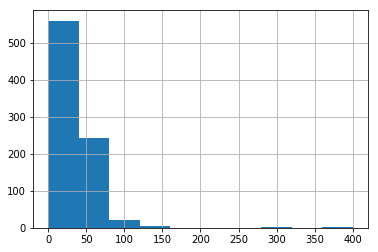

In [85]:
cluster_2['price'].hist()

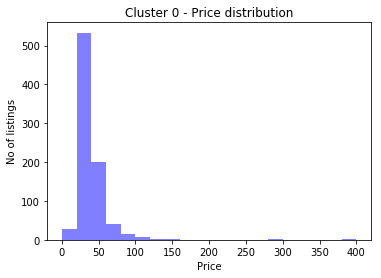

In [99]:
import matplotlib.mlab as mlab
num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(cluster_2['price'], num_bins, facecolor='blue', alpha=0.5)

# add a 'best fit' line
y = mlab.normpdf(bins, 30, 10)
#plt.plot(bins, y, 'r--')
plt.xlabel('Price')
plt.ylabel('No of listings')
plt.title('Cluster 0 - Price distribution')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

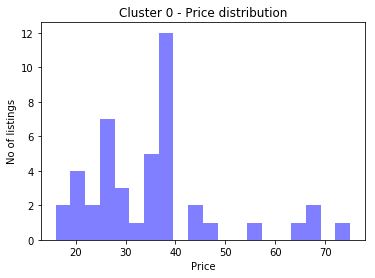

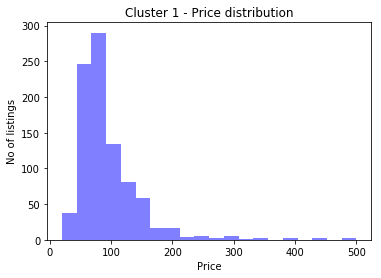

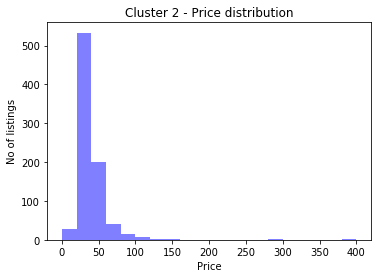

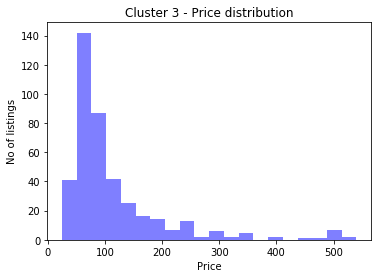

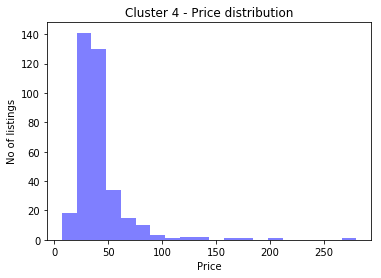

In [107]:
for item in range(0,5):
    #print(cluster)
    selected_cluster = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == item]
    
    n, bins, patches = plt.hist(selected_cluster['price'], num_bins, facecolor='blue', alpha=0.5)

    # add a 'best fit' line
    y = mlab.normpdf(bins, 30, 10)
    #plt.plot(bins, y, 'r--')
    plt.xlabel('Price')
    plt.ylabel('No of listings')
    plt.title('Cluster {} - Price distribution'.format(item))

    # Tweak spacing to prevent clipping of ylabel
    plt.subplots_adjust(left=0.15)
    plt.show()

### Room type

In [126]:
selected_cluster = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == 4]
    
selected_cluster.groupby('room_type').size()

room_type
Private room    358
Shared room       2
dtype: int64

### Minimum Nights

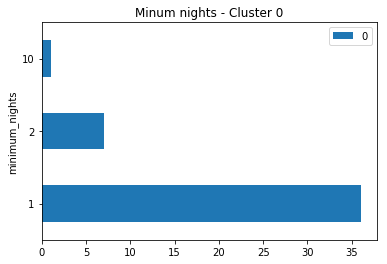

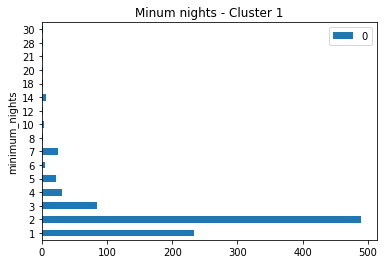

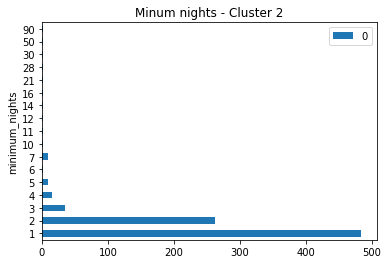

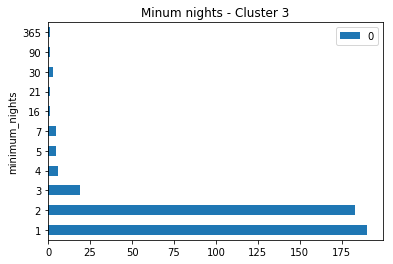

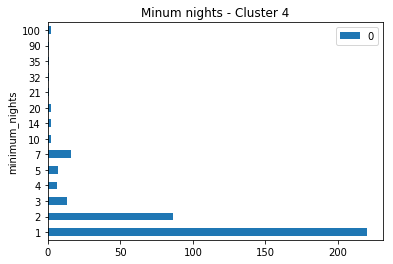

In [136]:
for item in range(0,5):
    selected_cluster = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == item]
    groups_night = selected_cluster.groupby('minimum_nights').size()
    df_nights = pd.DataFrame(groups_night)
    df_nights.plot(
        kind = 'barh',
        title = 'Minum nights - Cluster {}'.format(item)
        
    )
    

### Year round availability

In [159]:
selected_cluster = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == ]
selected_cluster['availability_365'].mean()
    

276.3333333333333

### Venue analysis

In [199]:
selected_cluster = df_cluster_analysis.loc[df_cluster_analysis['Cluster Labels'] == 1]
pd.DataFrame(selected_cluster.groupby('1st Most Common Venue').size(), columns = ['count']).sort_values(by='count', ascending=False)

count
1st Most Common Venue       
Pub                      259
Café                     143
Park                     126
Bar                       97
Coffee Shop               79
Playground                59
Brewery                   45
Grocery Store             23
Soccer Stadium            19
Indian Restaurant         17
Supermarket               10
Historic Site              8
Gym / Fitness Center       7
IT Services                5
Fast Food Restaurant       4
Convenience Store          4
Pharmacy                   3

In [204]:
import geopandas as gpd

ImportError: No module named 'geopandas'

In [ ]:
!conda install -c conda-forge geopandas=0.5.0

Solving environment: \ 

In [206]:
import geopandas as gpd

ImportError: libkea.so.1.4.7: cannot open shared object file: No such file or directory